# **Transfer Learning**

##### It refers to training pretrained/foundation models with the patterns they have learnt and their parameters and then fine tuning them on our specific datasets

In [1]:
import torch
import torchvision

print(f"Torch Version -> {torch.__version__}")
print(f"TorchVision Version -> {torchvision.__version__}")

Torch Version -> 2.4.0+cu124
TorchVision Version -> 0.19.0+cu124


In [2]:
from torch import nn
from torchinfo import summary
import matplotlib.pyplot as plt 
from Python_Modules import data_setup,engine

c:\Users\gaura\AppData\Local\Programs\Python\Python312\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
#Device agnostic code --> 
device = "cuda" if torch.cuda.is_available() else "cpu"

device

'cuda'

## Getting the Data -->

In [4]:
import os
import zipfile
from pathlib import Path
import requests

data_path = Path("data")
image_path = data_path / "pizza_steak_sushi"

if image_path.is_dir():
    print(f"The directory {image_path} already exists.")

else:
    image_path.mkdir(parents=True, exist_ok=True)
    
    with open(data_path/"pizza_steak_sushi.zip","wb") as f:
        request = requests.get("https://github.com/mrdbourke/pytorch-deep-learning/raw/main/data/pizza_steak_sushi.zip")
        f.write(request.content)
        
    with zipfile.ZipFile(data_path/"pizza_steak_sushi.zip" ,"r") as zip_ref:
        zip_ref.extractall(image_path)
    
    os.remove(data_path/"pizza_steak_sushi.zip")

The directory data\pizza_steak_sushi already exists.


In [5]:
train_dir = image_path/"train"
test_dir = image_path/"test"
train_dir,test_dir

(WindowsPath('data/pizza_steak_sushi/train'),
 WindowsPath('data/pizza_steak_sushi/test'))

## Creating Datasets and Dataloaders -> 

Now we've got some data, want to turn it into PyTorch Dataloaders.
Will use the `data_setup.py` module.

#### 1. Using manually created transforms.

All pre-trained models expect input images normalized in the same way, i.e. mini-batches of 3-channel RGB images of shape (3 x H x W), where H and W are expected to be at least 224.

The images have to be loaded in to a range of [0, 1] and then normalized using mean = [0.485, 0.456, 0.406] and std = [0.229, 0.224, 0.225].

In [28]:
from torchvision import transforms

#Data transformations
normalize = transforms.Normalize(mean=[0.485, 0.456,0.406],std=[0.229,0.224,0.225])

train_transforms= transforms.Compose([
    transforms.Resize(size=(224,224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456,0.406],std=[0.229,0.224,0.225]) #Distribution same as Imagenet
])


In [29]:
train_dataloader , test_dataloader , class_names = data_setup.create_dataloaders(train_dir=train_dir,test_dir=test_dir,transform=train_transforms,num_workers=os.cpu_count(),batch_size=16)

train_dataloader,test_dataloader,class_names

(<torch.utils.data.dataloader.DataLoader at 0x263e46d35f0>,
 ['pizza', 'steak', 'sushi'])

### **2. Using automatically created transforms.**

These "automatically created transforms" are already declared by the model that we are going to use.

#### Important Note -> When using any pretrained models, It is important that our data is **transformed** in the same way as the data on which the model was trained on. 

In [30]:
#Getting pretrained EffNet B0 -> 
weights = torchvision.models.EfficientNet_B0_Weights.DEFAULT
#BN -> Batch Normalization & #DEFAULT -> Best performing weights
weights

EfficientNet_B0_Weights.IMAGENET1K_V1

In [31]:
#Getting the auto transforms 
auto_transforms = weights.transforms()

auto_transforms

ImageClassification(
    crop_size=[224]
    resize_size=[256]
    mean=[0.485, 0.456, 0.406]
    std=[0.229, 0.224, 0.225]
    interpolation=InterpolationMode.BICUBIC
)

In [32]:
#Creating Dataloaders using automatic transforms -->
train_dataloader, test_dataloader,class_names = data_setup.create_dataloaders(train_dir=train_dir,test_dir=test_dir,transform=auto_transforms,batch_size=16,num_workers=os.cpu_count())

train_dataloader,test_dataloader,class_names

(<torch.utils.data.dataloader.DataLoader at 0x2639841ca70>,
 ['pizza', 'steak', 'sushi'])

### Getting a Pretrained Model -> 
Sources -> 
  1. PyTorch Domain Libraries
  2. HuggingFace
  3. Libraries like `timm` (torch image models)
  4. Paperswithcode

  Also when looking for a model we consider the accuracy/performance vs speed vs size tradeoff
  

In [33]:
#Creating of Pretrained Effnet B0 -> 

weights = torchvision.models.EfficientNet_B0_Weights.DEFAULT

model = torchvision.models.efficientnet_b0(weights=weights)

model

EfficientNet(
  (features): Sequential(
    (0): Conv2dNormActivation(
      (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): SiLU(inplace=True)
    )
    (1): Sequential(
      (0): MBConv(
        (block): Sequential(
          (0): Conv2dNormActivation(
            (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
            (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
            (2): SiLU(inplace=True)
          )
          (1): SqueezeExcitation(
            (avgpool): AdaptiveAvgPool2d(output_size=1)
            (fc1): Conv2d(32, 8, kernel_size=(1, 1), stride=(1, 1))
            (fc2): Conv2d(8, 32, kernel_size=(1, 1), stride=(1, 1))
            (activation): SiLU(inplace=True)
            (scale_activation): Sigmoid()
          )
          (2): Conv2dNormActivat

As the above model was trained on a different dataset, i.e. Imagenet, It has 1000 labels. While extracting features from this model, We wouldnt change the internal layer structure, But the input and output.

In **`Feature Extraction`** we dont change the layers, We only change the input data and output layers. Usually done on a smaller dataset. 

In **`Fine Tuning`** internal layers are also changed/unfreezed with large amounts of data to fit a dataset perfectly. Fine tuning is usually done top down.

In [34]:
summary(model, input_size=(16,3,224,224),col_names=['input_size', 'output_size', 'num_params','trainable'],col_width=18)

Layer (type:depth-idx)                                  Input Shape        Output Shape       Param #            Trainable
EfficientNet                                            [16, 3, 224, 224]  [16, 1000]         --                 True
├─Sequential: 1-1                                       [16, 3, 224, 224]  [16, 1280, 7, 7]   --                 True
│    └─Conv2dNormActivation: 2-1                        [16, 3, 224, 224]  [16, 32, 112, 112] --                 True
│    │    └─Conv2d: 3-1                                 [16, 3, 224, 224]  [16, 32, 112, 112] 864                True
│    │    └─BatchNorm2d: 3-2                            [16, 32, 112, 112] [16, 32, 112, 112] 64                 True
│    │    └─SiLU: 3-3                                   [16, 32, 112, 112] [16, 32, 112, 112] --                 --
│    └─Sequential: 2-2                                  [16, 32, 112, 112] [16, 16, 112, 112] --                 True
│    │    └─MBConv: 3-4                              

As noticable, The output linear layer has 1000 output features as per the imagenet dataset. But for suiting it to our needs, We need to change it to 3.

In [35]:
#Freezing the base model and changing the output model to suit our needs.
#In most feature extractor models we would just change output layers and not the base layers.

In [36]:
for params in model.features.parameters():
    params.requires_grad=False
    #As the gradients wont be noticed, Weights and Biases wont be updated making them "freezed"
    

In [37]:
#Checked with summary(model and features trainable is now false.)

In [38]:
#Updating the classifier head -> 
model.classifier

model.classifier = nn.Sequential(
    nn.Dropout(p=0.2,inplace=True),
    nn.Linear(in_features=1280, out_features=3, bias=True)
).to(device)

model.classifier

Sequential(
  (0): Dropout(p=0.2, inplace=True)
  (1): Linear(in_features=1280, out_features=3, bias=True)
)

In [39]:
summary(model, input_size=(16,3,224,224),col_names=['input_size', 'output_size', 'num_params','trainable'],col_width=18)

Layer (type:depth-idx)                                  Input Shape        Output Shape       Param #            Trainable
EfficientNet                                            [16, 3, 224, 224]  [16, 3]            --                 Partial
├─Sequential: 1-1                                       [16, 3, 224, 224]  [16, 1280, 7, 7]   --                 False
│    └─Conv2dNormActivation: 2-1                        [16, 3, 224, 224]  [16, 32, 112, 112] --                 False
│    │    └─Conv2d: 3-1                                 [16, 3, 224, 224]  [16, 32, 112, 112] (864)              False
│    │    └─BatchNorm2d: 3-2                            [16, 32, 112, 112] [16, 32, 112, 112] (64)               False
│    │    └─SiLU: 3-3                                   [16, 32, 112, 112] [16, 32, 112, 112] --                 --
│    └─Sequential: 2-2                                  [16, 32, 112, 112] [16, 16, 112, 112] --                 False
│    │    └─MBConv: 3-4                      

Noticable points -> 
- Only Output layer is trainable as we did model.features.parameters -> requires_grad = false 
- As we have changed the number of output channels to 3 from 1000, There is a fall in number of paramters by over 1 million.

## Training the Model -> 


In [40]:
loss_fn = torch.nn.CrossEntropyLoss()

optimizer = torch.optim.Adam(params=model.parameters(), lr = 0.001)

#Importing the train function from Python_Modules/train.py

from Python_Modules import engine
from timeit import default_timer as timer

In [41]:
torch.manual_seed(42)
torch.cuda.manual_seed(42)

In [42]:
startTime = timer()

results = engine.train(model=model,
                       train_dataloader=train_dataloader,
                       test_dataloader=test_dataloader,
                       loss_fn=loss_fn,
                       optimizer=optimizer,
                       epochs=10,
                       device=device)

 10%|█         | 1/10 [00:14<02:06, 14.09s/it]

Epoch: 1 | train_loss: 1.0235 | train_acc: 0.4500 | test_loss: 0.8145 | test_acc: 0.7648


 20%|██        | 2/10 [00:28<01:52, 14.04s/it]

Epoch: 2 | train_loss: 0.7588 | train_acc: 0.8292 | test_loss: 0.6601 | test_acc: 0.8875


 30%|███       | 3/10 [00:41<01:35, 13.59s/it]

Epoch: 3 | train_loss: 0.6314 | train_acc: 0.8458 | test_loss: 0.5995 | test_acc: 0.8693


 40%|████      | 4/10 [00:54<01:20, 13.47s/it]

Epoch: 4 | train_loss: 0.5361 | train_acc: 0.9208 | test_loss: 0.4950 | test_acc: 0.8750


 50%|█████     | 5/10 [01:08<01:08, 13.65s/it]

Epoch: 5 | train_loss: 0.4801 | train_acc: 0.8417 | test_loss: 0.5092 | test_acc: 0.8761


 60%|██████    | 6/10 [01:21<00:54, 13.57s/it]

Epoch: 6 | train_loss: 0.4373 | train_acc: 0.8292 | test_loss: 0.4488 | test_acc: 0.8636


 70%|███████   | 7/10 [01:34<00:40, 13.35s/it]

Epoch: 7 | train_loss: 0.3976 | train_acc: 0.8667 | test_loss: 0.4294 | test_acc: 0.8761


 80%|████████  | 8/10 [01:48<00:26, 13.39s/it]

Epoch: 8 | train_loss: 0.3913 | train_acc: 0.8583 | test_loss: 0.4294 | test_acc: 0.8886


 90%|█████████ | 9/10 [02:01<00:13, 13.39s/it]

Epoch: 9 | train_loss: 0.4249 | train_acc: 0.8625 | test_loss: 0.4086 | test_acc: 0.8511


100%|██████████| 10/10 [02:14<00:00, 13.45s/it]

Epoch: 10 | train_loss: 0.3848 | train_acc: 0.8375 | test_loss: 0.3820 | test_acc: 0.8693


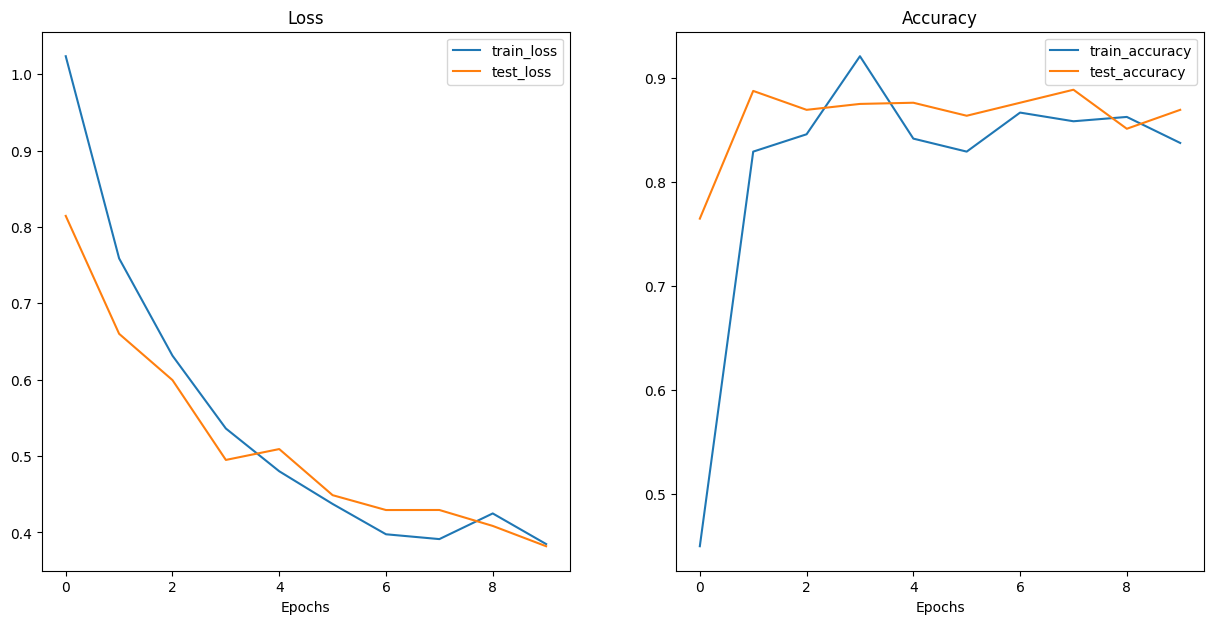

In [43]:
#Plotting the results of this model -> 
from Python_Modules import helper_functions
helper_functions.plot_loss_curves(results=results)

### Predicting on random dataset images to analyse qualitatively -> 

The custom data should be on same device, same datatype, same shape, same transformation. 

- Same shape - If our images are different shapes to what our model was trained on, we'll get shape errors.
- Same datatype - If our images are a different datatype (e.g. torch.int8 vs. torch.float32) we'll get datatype errors.
- Same device - If our images are on a different device to our model, we'll get device errors.
- Same transformations - If our model is trained on images that have been transformed in certain way (e.g. normalized with a specific mean and standard deviation) and we try and make predictions on images transformed in a different way, these predictions may be off.
Note: These requirements go for all kinds of data if you're trying to make predictions with a trained model. Data you'd like to predict on should be in the same format as your model was trained on.

To do all of this, we'll create a function pred_and_plot_image() to:

1. Take in a trained model, a list of class names, a filepath to a target image, an image size, a transform and a target device.
2. Open an image with PIL.Image.open().
3. Create a transform for the image (this will default to the manual_transforms we created above or it could use a transform generated from weights.transforms()).
4. Make sure the model is on the target device.
5. Turn on model eval mode with model.eval() (this turns off layers like nn.Dropout(), so they aren't used for inference) and the inference mode context manager.
6. Transform the target image with the transform made in step 3 and add an extra batch dimension with torch.unsqueeze(dim=0) so our input image has shape [batch_size, color_channels, height, width].
7. Make a prediction on the image by passing it to the model ensuring it's on the target device.
8. Convert the model's output logits to prediction probabilities with torch.softmax().
9. Convert model's prediction probabilities to prediction labels with torch.argmax().
10. Plot the image with matplotlib and set the title to the prediction label from step 9 and prediction probability from step 8. 

In [47]:
from typing import Tuple, List

from PIL import Image

def pred_and_plot_image(model:torch.nn.Module,
                        image_path:str,
                        class_names:List[str],
                        image_size: Tuple[int,int]=(224,224),
                        transform:torchvision.transforms=None,
                        device:torch.device=device):
    
    img=Image.open(image_path)
    
    if transform is not None:
        image_transform = transform
    else:
        image_transform = transforms.Compose([
            transforms.Resize(size=(224,224)),
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.485, 0.456,0.406],std=[0.229,0.224,0.225])
        ]
        )
        
    model.to(device)
    
    model.eval()
    
    with torch.inference_mode():
        transformed_image = image_transform(img).unsqueeze(0) #Adds Batch Dimension
        
        target_image_pred = model(transformed_image.to(device))
        
        target_image_pred_probs = torch.softmax(target_image_pred, dim=1)

        target_image_pred_label = torch.argmax(target_image_pred_probs, dim=1)
        plt.figure()
        plt.imshow(img)
        plt.title(f"Pred: {class_names[target_image_pred_label]} | Prob: {target_image_pred_probs.max():.3f}")
        plt.axis(False);

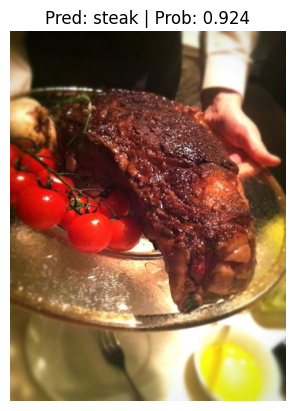

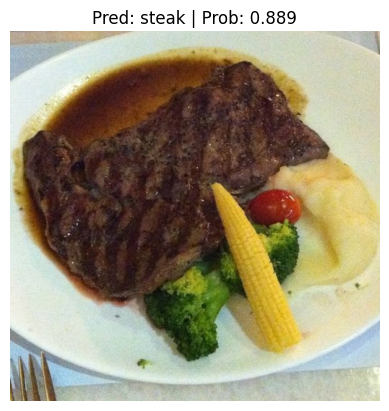

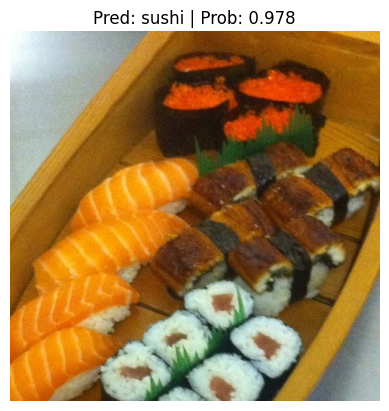

In [51]:
import random
num_images_to_plot = 3
test_image_path_list = list(Path(test_dir).glob("*/*.jpg")) # get list all image paths from test data 
test_image_path_sample = random.sample(population=test_image_path_list, # go through all of the test image paths
                                       k=num_images_to_plot) # randomly select 'k' image paths to pred and plot


for image_path in test_image_path_sample:
    pred_and_plot_image(model=model, 
                        image_path=image_path,
                        class_names=class_names,
                        image_size=(224, 224))


### Making predictions on custom random image -> 

In [86]:
data_path = Path("data")
data_path

WindowsPath('data')

In [90]:
import requests

custom_image_path = data_path / r'random_image.jpg'

if not custom_image_path.is_file():
    with open(custom_image_path,"wb") as f:
        request=requests.get("https://www.allrecipes.com/thmb/0xH8n2D4cC97t7mcC7eT2SDZ0aE=/1500x0/filters:no_upscale():max_bytes(150000):strip_icc()/6776_Pizza-Dough_ddmfs_2x1_1725-fdaa76496da045b3bdaadcec6d4c5398.jpg")
        f.write(request.content)

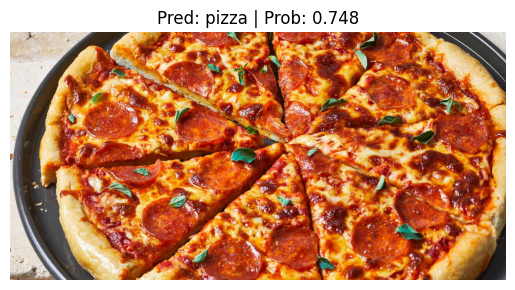

In [91]:
pred_and_plot_image(model,custom_image_path,class_names)